In [1]:
using Plots
using LES_ML
using LaTeXStrings
using CUDA
using Distributions

[ Info: Precompiling LES_ML [9bca47e3-315e-42b6-a9a0-21ad79062dce]


In [2]:
N = (256,256)
UPC = 2       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (8,8) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0

FA_filter = gen_FA_filter(J,2) #|> gpu


┌ Info: The CUDA function is being called but CUDA.jl is not functional.
└ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = ConvTranspose((8, 8), 2 => 2, stride=8, bias=false)  # 256 parameters
│   summary(x) = "32×32×2×1 Array{Float64, 4}"
└ @ Flux ~/.julia/packages/Flux/MtsAN/src/layers/stateless.jl:60


Conv((8, 8), 2 => 2, stride=8, bias=false)  # 256 parameters

In [3]:
forcing(x) = sin.(4*x[2])

F = fine_mesh.eval_function(forcing)
F = cat(F,zeros(size(F)),dims = fine_mesh.dims + 1)



256×256×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689  …  -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 0.0490677  0.14673  0.24298  0.33689     -0.24298  -0.14673  -0.0490677
 ⋮   

In [4]:
setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)

LES_ML.setup_struct(LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#86"{Float64, Int64}(0.1963495408493623, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false)), LES_ML.var"#pressure_poisson#40"{LES_ML.var"#pressure_poisson#32#41", Array{Float64, 4}}(LES_ML.var"#pressure_poisson#32#41"(Core.Box(2)), Core.Box([0.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]), [1.0 0.9967912836197286 … 3.948859004456395 0.9967912836197286; 0.9967912836197286 1.9935825672394571 … 4.9456502880761235 1.9935825672394571; … ; 3.948859004456395 4.9456502880761235 … 7.89771800891279 4.9456502880761235; 0.9967912836197286 1.9935825672394571 … 4.9456502880761235 1.9935825672394571;;;;]), LES_ML.grid_swapper(LES_ML.mesh_struct(2, (32, 32), [-3.043417883165112 -3.043417883165112

In [5]:
setup.O.G.weight

3×3×1×2 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0    0.0     0.0
 0.0  -40.7437  0.0
 0.0   40.7437  0.0

[:, :, 1, 2] =
 0.0    0.0      0.0
 0.0  -40.7437  40.7437
 0.0    0.0      0.0

In [6]:
max_k = 10
energy_norm = 1
number_of_simulations = 1

setup = gen_setup(fine_mesh)
setup_bar = gen_setup(coarse_mesh)
KF_rhs = gen_rhs(setup,0*F;Re = 1000,damping = 0.0)

V = gen_random_field(fine_mesh.N,max_k,norm = energy_norm,samples = (fine_mesh.UPC,number_of_simulations))


    
MV = setup.O.M(padding(V,(1,1),circular = true))



p = setup.PS(MV)

Gp = setup.O.G(padding(p,(1,1),circular =true))

V0 = V-Gp

setup.O.M(V0)[:,:,1,1]

KF_rhs(V0,fine_mesh,0)


256×256×2×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.374028  -0.426035  -0.473989  -0.512806  …  -0.277559   -0.323005
 -0.375968  -0.436443  -0.491256  -0.534739     -0.260194   -0.315484
 -0.375423  -0.444626  -0.506627  -0.555131     -0.239954   -0.30527
 -0.372247  -0.450334  -0.51978   -0.573765     -0.217124   -0.292388
 -0.36608   -0.45305   -0.530271  -0.590221     -0.191849   -0.276724
 -0.356428  -0.452191  -0.537279  -0.603775  …  -0.164064   -0.257919
 -0.342541  -0.446838  -0.540018  -0.613631     -0.133587   -0.235554
 -0.323691  -0.436141  -0.537508  -0.618794     -0.100069   -0.209009
 -0.299186  -0.419313  -0.528869  -0.618541     -0.063081   -0.17774
 -0.268613  -0.395806  -0.513639  -0.61227      -0.0222948  -0.141394
 -0.231814  -0.365637  -0.491706  -0.59999   …   0.0224924  -0.0997046
 -0.189276  -0.329293  -0.463644  -0.582155      0.0710615  -0.0531302
 -0.142041  -0.287955  -0.430797  -0.560157      0.122999   -0.00246221
  ⋮                                       

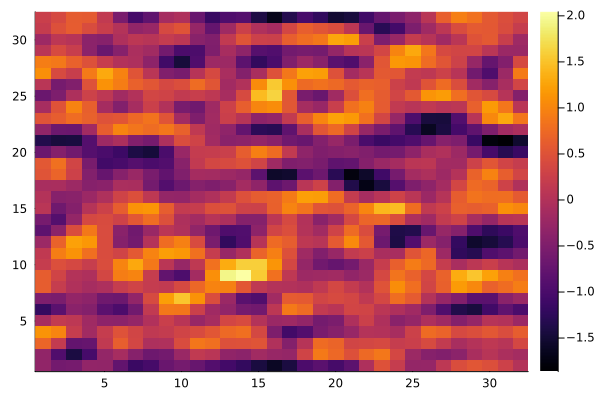

In [7]:
heatmap(Array(FA_filter(V0))[:,:,2,1])

In [8]:
dt = 0.01
save_every = 10
t_start = 0
t_end = 5
pre_allocate = true

t_data,sim_data = simulate(V0,fine_mesh,dt,t_start,t_end,KF_rhs,save_every = save_every,pre_allocate = pre_allocate) 
0

0.0%┣                                            ┫ 0/500 [00:01<-11:-48, -1s/it]
0.2%┣                                          ┫ 1/500 [00:02<Inf:Inf, InfGs/it]
0.4%┣▏                                              ┫ 2/500 [00:03<22:48, 3s/it]
0.6%┣▎                                              ┫ 3/500 [00:03<11:39, 1s/it]
0.8%┣▍                                              ┫ 4/500 [00:03<07:56, 1it/s]
1.0%┣▌                                              ┫ 5/500 [00:03<06:05, 1it/s]
1.2%┣▋                                              ┫ 6/500 [00:03<04:58, 2it/s]
1.4%┣▋                                              ┫ 7/500 [00:03<04:13, 2it/s]
1.6%┣▊                                              ┫ 8/500 [00:03<03:41, 2it/s]
1.8%┣▉                                              ┫ 9/500 [00:03<03:17, 2it/s]
2.0%┣█                                             ┫ 10/500 [00:04<03:29, 2it/s]
2.2%┣█                                             ┫ 11/500 [00:04<03:13, 3it/s]
2.4%┣█                      

20.6%┣████████▉                                  ┫ 103/500 [00:10<00:40, 10it/s]
20.8%┣█████████                                  ┫ 104/500 [00:10<00:40, 10it/s]
21.0%┣█████████                                  ┫ 105/500 [00:10<00:40, 10it/s]
21.2%┣█████████▏                                 ┫ 106/500 [00:11<00:40, 10it/s]
21.4%┣█████████▏                                 ┫ 107/500 [00:11<00:39, 10it/s]
21.6%┣█████████▎                                 ┫ 108/500 [00:11<00:39, 10it/s]
21.8%┣█████████▍                                 ┫ 109/500 [00:11<00:39, 10it/s]
22.0%┣█████████▌                                 ┫ 110/500 [00:11<00:39, 10it/s]
22.2%┣█████████▌                                 ┫ 111/500 [00:11<00:39, 10it/s]
22.4%┣█████████▋                                 ┫ 112/500 [00:11<00:38, 10it/s]
22.6%┣█████████▊                                 ┫ 113/500 [00:11<00:38, 10it/s]
22.8%┣█████████▉                                 ┫ 114/500 [00:11<00:38, 10it/s]
23.0%┣██████████            

41.0%┣█████████████████▋                         ┫ 205/500 [00:17<00:25, 12it/s]
41.2%┣█████████████████▊                         ┫ 206/500 [00:17<00:25, 12it/s]
41.4%┣█████████████████▉                         ┫ 207/500 [00:18<00:25, 12it/s]
41.6%┣█████████████████▉                         ┫ 208/500 [00:18<00:25, 12it/s]
41.8%┣██████████████████                         ┫ 209/500 [00:18<00:25, 12it/s]
42.0%┣██████████████████                         ┫ 210/500 [00:18<00:25, 12it/s]
42.2%┣██████████████████▏                        ┫ 211/500 [00:18<00:25, 12it/s]
42.4%┣██████████████████▎                        ┫ 212/500 [00:18<00:24, 12it/s]
42.6%┣██████████████████▎                        ┫ 213/500 [00:18<00:24, 12it/s]
42.8%┣██████████████████▍                        ┫ 214/500 [00:18<00:24, 12it/s]
43.0%┣██████████████████▌                        ┫ 215/500 [00:18<00:24, 12it/s]
43.2%┣██████████████████▋                        ┫ 216/500 [00:18<00:24, 12it/s]
43.4%┣██████████████████▋   

61.4%┣██████████████████████████▍                ┫ 307/500 [00:24<00:15, 12it/s]
61.6%┣██████████████████████████▌                ┫ 308/500 [00:25<00:15, 12it/s]
61.8%┣██████████████████████████▋                ┫ 309/500 [00:25<00:15, 13it/s]
62.0%┣██████████████████████████▋                ┫ 310/500 [00:25<00:15, 13it/s]
62.2%┣██████████████████████████▊                ┫ 311/500 [00:25<00:15, 13it/s]
62.4%┣██████████████████████████▉                ┫ 312/500 [00:25<00:15, 13it/s]
62.6%┣███████████████████████████                ┫ 313/500 [00:25<00:15, 13it/s]
62.8%┣███████████████████████████                ┫ 314/500 [00:25<00:15, 13it/s]
63.0%┣███████████████████████████                ┫ 315/500 [00:25<00:15, 13it/s]
63.2%┣███████████████████████████▏               ┫ 316/500 [00:25<00:15, 13it/s]
63.4%┣███████████████████████████▎               ┫ 317/500 [00:25<00:15, 13it/s]
63.6%┣███████████████████████████▍               ┫ 318/500 [00:25<00:15, 13it/s]
63.8%┣██████████████████████

82.0%┣███████████████████████████████████▎       ┫ 410/500 [00:32<00:07, 13it/s]
82.2%┣███████████████████████████████████▍       ┫ 411/500 [00:32<00:07, 13it/s]
82.4%┣███████████████████████████████████▍       ┫ 412/500 [00:32<00:07, 13it/s]
82.6%┣███████████████████████████████████▌       ┫ 413/500 [00:32<00:07, 13it/s]
82.8%┣███████████████████████████████████▋       ┫ 414/500 [00:32<00:07, 13it/s]
83.0%┣███████████████████████████████████▊       ┫ 415/500 [00:32<00:07, 13it/s]
83.2%┣███████████████████████████████████▊       ┫ 416/500 [00:32<00:07, 13it/s]
83.4%┣███████████████████████████████████▉       ┫ 417/500 [00:32<00:06, 13it/s]
83.6%┣████████████████████████████████████       ┫ 418/500 [00:32<00:06, 13it/s]
83.8%┣████████████████████████████████████       ┫ 419/500 [00:32<00:06, 13it/s]
84.0%┣████████████████████████████████████▏      ┫ 420/500 [00:33<00:06, 13it/s]
84.2%┣████████████████████████████████████▏      ┫ 421/500 [00:33<00:06, 13it/s]
84.4%┣██████████████████████

0

[ Info: Saved animation to /home/toby/Projects/LES_ML.jl/DNS_flow.gif


Plots.AnimatedGif("/home/toby/Projects/LES_ML.jl/DNS_flow.gif")
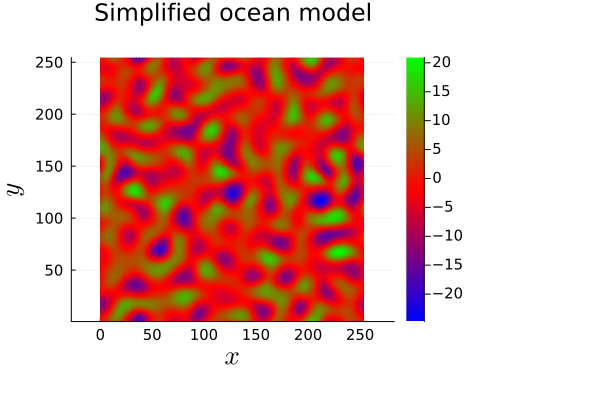

In [9]:
to_plot = Array(setup.O.w(sim_data[:,:,:,1,:]))[:,:,1,:]
#to_plot = setup_bar.O.w(pred_sim[:,:,1:2,:])[:,:,1,:]


ymin = minimum(to_plot)
ymax = maximum(to_plot)


anim = @animate for index in 1:size(to_plot)[3]
    Plots.heatmap(to_plot[:,:,index]',color = :brg,clim = (ymin,ymax),yflip=false,xtickfontsize = 10,ytickfontsize = 10
    ,aspect_ratio = :equal,titlefontsize=16,yguidefontsize=18,xguidefontsize=18,title = "Simplified ocean model",right_margin = 35Plots.mm)
    Plots.xlabel!(L"x")
    Plots.ylabel!(L"y")
    #title!(L"t = " * string(round(example_t[index],digits = 1)))
end

gif(anim, "DNS_flow.gif", fps = 30)

In [10]:
E = Array(fine_mesh.ip(sim_data,sim_data))[1:end]
E_bar = Array(coarse_mesh.ip(MP.FA_filter(sim_data[:,:,:,1,:]),MP.FA_filter(sim_data[:,:,:,1,:])))[1:end]

50-element Vector{Float64}:
 35.79827306572284
 35.52558514437935
 35.28576637448845
 35.055202947926404
 34.866033152189374
 34.66242569645328
 34.445940510631324
 34.23621377075243
 34.04584555204396
 33.90062953876081
 33.71988856027781
 33.518177997555526
 33.34954310717917
  ⋮
 30.474755076793045
 30.394385937976676
 30.29843391017087
 30.242369032195647
 30.1718035270751
 30.09468040403287
 30.032399537609734
 29.97356688008046
 29.892848728668795
 29.814396530539177
 29.752173144719073
 29.675857514462237

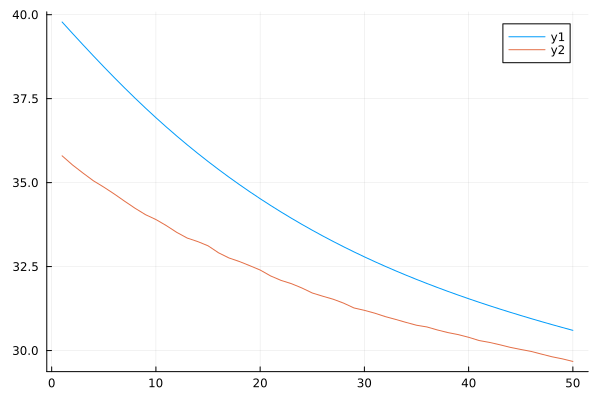

In [11]:
plot(E)
plot!(E_bar)

In [12]:
setup.O

LES_ML.operators_struct(Conv((3, 3), 2 => 1, bias=false), Conv((3, 3), 1 => 2, bias=false), LES_ML.var"#C#86"{Float64, Int64}(0.024543692606170175, Core.Box(Conv((3, 3), 2 => 4, bias=false)), Core.Box(Conv((3, 3), 2 => 4, bias=false)), 2, Core.Box(Conv((3, 3), 4 => 2, bias=false))), Conv((3, 3), 2 => 2, bias=false), Conv((3, 3), 2 => 1, bias=false))

In [13]:
using Flux

struct smagorinsky_operators_struct
    S
    SS
    div
end

function gen_permutations(N)

    N_grid = [collect(1:n) for n in N]

    sub_grid = ones(Int,(N...))

    dims = length(N)
    sub_grids = []

    for i in 1:dims
        original_dims = collect(1:dims)
        permuted_dims = copy(original_dims)
        permuted_dims[1] = original_dims[i]
        permuted_dims[i] = 1


        push!(sub_grids,permutedims(N_grid[i] .*  permutedims(sub_grid,permuted_dims),permuted_dims))

    end

    return reverse(reshape(cat(sub_grids...,dims = dims + 1),(prod(N)...,dims)),dims =2 )
end


function gen_smagorinsky_operators(mesh)
    dims = mesh.dims
    use_GPU = mesh.use_GPU
    h = CUDA.@allowscalar(mesh.dx[1])


    UPC = mesh.UPC

    @assert dims != 3 "Convection for dims = 3 is not yet supported"

    stenc_3 = zeros(([3 for i in 1:dims]...))
    select = [(:);[2 for i in 1:dims-1]]

    div = Conv(([3 for i in 1:dims]...,), UPC=>1,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    for i in 1:UPC
        
        for j in 1:UPC
            stencil = copy(stenc_3)
            if i == j 
                stencil[circshift(select,(i-1,))...] .= 1/h * [0,-1,1]
            end
            div.weight[[(:) for k in 1:dims]...,i,1] .= stencil
        end
    end


    S = Conv(([3 for i in 1:dims]...,), UPC=>sum(collect(1:UPC)),stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    S.weight .= 0
    perms = gen_permutations((dims,dims))
    counter = 1
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        

        stencil_1 = copy(stenc_3)
        stencil_2 = copy(stenc_3)
        stencil_1[circshift(select,(index_1-1,))...] .= 1/(2*h) * [1,-1,0]
        stencil_2[circshift(select,(index_2-1,))...] .= 1/(2*h) * [1,-1,0]

        if index_1 <= index_2 
            S.weight[[(:) for k in 1:dims]...,index_2,counter] .+= stencil_1
            S.weight[[(:) for k in 1:dims]...,index_1,counter] .+= stencil_2
            counter += 1
        end
    end
    

    div = Conv(([3 for i in 1:dims]...,), sum(collect(1:UPC))=>UPC,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    perms = gen_permutations((dims,dims))
    counter = 1
    div.weight .= 0
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        

        stencil_1 = copy(stenc_3)
        stencil_2 = copy(stenc_3)
        stencil_1[circshift(select,(index_1-1,))...] .= 1/h * [0,-1,1]
        stencil_2[circshift(select,(index_2-1,))...] .= 1/h * [0,-1,1]

        if index_1 <= index_2 
            div.weight[[(:) for k in 1:dims]...,counter,index_2] .= stencil_1
            div.weight[[(:) for k in 1:dims]...,counter,index_1] .= stencil_2
            counter += 1
        end
    end


    SS = Conv(([1 for i in 1:dims]...,), sum(collect(1:UPC))=>1,stride = ([1 for i in 1:dims]...,),pad = 0,bias =false)  # First convolution, operating upon a 28x28 image
    perms = gen_permutations((dims,dims))
    counter = 1
    SS.weight .= 1
    for i in 1:size(perms)[1]
        perm = perms[i,:]
        index_1 = perm[1]
        index_2 = perm[2]
        


        if index_1 <= index_2 
            if index_1 != index_2
                SS.weight[[(:) for k in 1:dims]...,counter,1] .= 2
            end
            counter += 1
        end
    end



    if use_GPU
        div = div |> gpu
        S = S |> gpu
        SS = SS |> gpu

    end



    return smagorinsky_operators_struct(S,SS,div)#,Q,Q_T,D
end

gen_smagorinsky_operators (generic function with 1 method)

In [14]:
SO = gen_smagorinsky_operators(fine_mesh)
SO.SS.weight

1×1×3×1 Array{Float32, 4}:
[:, :, 1, 1] =
 1.0

[:, :, 2, 1] =
 2.0

[:, :, 3, 1] =
 1.0

In [15]:
u_bar = MP.FA_filter(sim_data[:,:,:,1,:])

32×32×2×50 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.594784   -0.742577    0.0148627  …  -0.179231    -0.223827   -0.067139
 -0.320065   -0.74909    -0.239405      -0.00833337   0.0956379   0.303385
  0.3161     -0.357731   -0.715285       0.113479     0.209992    0.531446
  0.817527    0.453317   -0.839446       0.2118      -0.0225574   0.211027
  0.946999    1.22661    -0.530845       0.315925    -0.278838   -0.302919
  0.820719    1.44027    -0.273403   …   0.328238    -0.33171    -0.589457
  0.513425    1.07116    -0.171787       0.0362656   -0.193957   -0.491174
  0.432601    0.784986   -0.0231347     -0.463772    -0.192458   -0.064012
  0.778335    0.97195     0.235674      -0.446859    -0.285141    0.275883
  1.02802     1.33724     0.53521       -0.161105    -0.147861    0.3565
  0.778721    1.39213     0.762499   …  -0.0156517   -0.0947342   0.0622797
  0.0819658   1.11452     0.951043      -0.0156542   -0.444243   -0.708215
 -0.815176    0.521382    0.930222      -0.139671    -0.

In [16]:
function smagorinsky_model(u_bar,mesh,Cs,SO)
    h =  stop_gradient() do 
        CUDA.@allowscalar(mesh.dx[1])
    end
    
    u_pad = padding(u_bar,(2,2),circular = true)
    
    S = SO.S(u_pad)
    
    SS = sqrt.(SO.SS(S.^2))
    if length(size(Cs)) > 1
        vt = padding(Cs.^2,(1,1),circular = true) .* SS
    else
        vt = Cs .^2 .* SS
    end
    
    return SO.div(h * vt .* S)
end

function div_model(tau,mesh,SO)
    
    tau_pad = padding(tau,(1,1),circular = true)

    return SO.div(tau_pad)
end

div_model (generic function with 1 method)

In [17]:
using Random
using Distributions

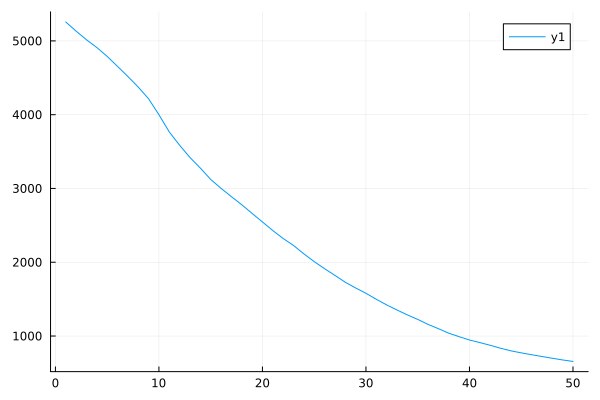

In [18]:
lit = smagorinsky_model(sim_data[:,:,:,1,:],coarse_mesh,[1.],SO)
Cs = rand(Normal(2,1),(size(sim_data)[1:2]))
lit2 = smagorinsky_model(sim_data[:,:,:,1,:],coarse_mesh,Cs,SO)
plot(Array(fine_mesh.ip(sim_data[:,:,:,1,:],lit2))[1:end])

# Build all the closure models & check on conservative properties

In [19]:
r = 2
BC = "c"
channels = [2*r,30,30]
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (1,1)
constrain_energy = true
conserve_momentum = true

skew_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

LES_ML.model_struct(LES_ML.var"#NN#256"{String, Bool, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, LES_ML.var"#NN#250#257", Vector{Array{Float32, 4}}}(Core.Box(2), "c", true, true, true, false, 2, (1, 1), LES_ML.var"#NN#250#257"(Core.Box([-0.3734712 -0.07655629 -0.3816613; 0.06406893 -0.18157649 -0.3529926; 0.028588353 -0.18312892 0.01912603;;; 0.10414897 -0.121573985 -0.14053917; 0.12199958 0.20166695 -0.12642804; -0.23269859 0.32328176 0.09005798;;;; 0.27942687 0.10649326 -0.28438878; -0.05212254 0.23627551 -0.096069075; -0.24980168 -0.2764773 0.19633178;;; -0.2528075 0.2727591 0.06955569; -0.18732786 0.007429795 -0.2706914; 0.10438111 0.33206803 0.40126163]), Core.Box([-0.13219365 0.34924227 -0.26703325; -0.32590997 -0.00039103927 -0.17684771; 0.3352572 -0.39838564 -0.31044766;;; 0.3103351 -0.026622936 -0.29944927; -0.24281383 -0.10739603 -0.3658842; 0.15428512 0.25177303 -0.05102262;;;; 0.25063348 -0.39703065 -0.2414018; -0.18920378 0.15559933 0.059983283; 0.27307597 0.4026393 -0.

In [20]:
r = 2 # output dimension
BC = "c"
channels = [4,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (1,1)
constrain_energy = true
conserve_momentum = true

skew_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

LES_ML.model_struct(LES_ML.var"#NN#256"{String, Bool, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, LES_ML.var"#NN#250#257", Vector{Array{Float32, 4}}}(Core.Box(2), "c", true, true, true, false, 2, (1, 1), LES_ML.var"#NN#250#257"(Core.Box([-0.15477256 0.08574569 0.17270319; 0.12433365 -0.11874585 0.14635108; -0.375467 -0.22710817 0.078169994;;; -0.2763046 -0.29692686 -0.32547078; 0.29866362 -0.221795 -0.21017058; 0.38804567 0.30252588 0.34182414;;;; 0.21082258 -0.13672961 0.21737126; 0.02000043 -0.072270624 -0.3261213; -0.32211664 0.03653947 0.070764676;;; -0.387736 0.15935801 0.29189128; -0.023185976 0.40156472 -0.05437081; 0.30688834 0.13006331 0.070122465]), Core.Box([0.086408146 -0.17424154 0.35652834; 0.3330607 -0.103238456 0.27616838; -0.2802832 -0.3821301 -0.28553993;;; 0.08406711 -0.05893256 0.15341222; -0.19819053 0.30411327 -0.23631518; 0.06314571 -0.062146723 -0.2244925;;;; 0.12624744 -0.07197104 0.22176617; -0.13818535 0.012162222 0.043719064; -0.2620095 0.28890997 -0.14048

In [21]:
r = 2
BC = "c"
channels = [4,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

plain_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

LES_ML.model_struct(LES_ML.var"#NN#256"{String, Bool, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, LES_ML.var"#NN#250#257", Vector{Int64}}(Core.Box(2), "c", false, false, true, false, 2, (0, 0), LES_ML.var"#NN#250#257"(Core.Box(0), Core.Box(0), Core.Box(0), Core.Box(2)), [0, 0, 0], Core.Box((3, 3)), Core.Box(Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 2)))), Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 2)), 2, (0, 0), [0, 0, 0], 2, (3, 3), "c", false, false, true, [(1, 1), (1, 1), (1, 1)], [4, 30, 30, 2], [(1, 1), (1, 1), (1, 1)])

In [22]:
r = 3
BC = "c"
channels = [4,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

div_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

LES_ML.model_struct(LES_ML.var"#NN#256"{String, Bool, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, LES_ML.var"#NN#250#257", Vector{Int64}}(Core.Box(2), "c", false, false, true, false, 3, (0, 0), LES_ML.var"#NN#250#257"(Core.Box(0), Core.Box(0), Core.Box(0), Core.Box(2)), [0, 0, 0], Core.Box((3, 3)), Core.Box(Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 3)))), Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 3)), 3, (0, 0), [0, 0, 0], 2, (3, 3), "c", false, false, true, [(1, 1), (1, 1), (1, 1)], [4, 30, 30, 3], [(1, 1), (1, 1), (1, 1)])

In [23]:
r = 1
BC = "c"
channels = [4,30,30] # inputs: u,v,du/dt,dv/dt,viscosity
strides = [(1,1),(1,1),(1,1)]
kernel_sizes = [(1,1),(1,1),(1,1)]
B = (0,0)
constrain_energy = false
conserve_momentum = false

smag_NN = gen_NN(kernel_sizes,channels,strides,r,B;boundary_padding = BC,constrain_energy = constrain_energy, conserve_momentum = conserve_momentum)

LES_ML.model_struct(LES_ML.var"#NN#256"{String, Bool, Bool, Bool, Bool, Int64, Tuple{Int64, Int64}, LES_ML.var"#NN#250#257", Vector{Int64}}(Core.Box(2), "c", false, false, true, false, 1, (0, 0), LES_ML.var"#NN#250#257"(Core.Box(0), Core.Box(0), Core.Box(0), Core.Box(2)), [0, 0, 0], Core.Box((3, 3)), Core.Box(Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 1)))), Chain(Conv((3, 3), 4 => 30, relu), Conv((3, 3), 30 => 30, relu), Conv((3, 3), 30 => 1)), 1, (0, 0), [0, 0, 0], 2, (3, 3), "c", false, false, true, [(1, 1), (1, 1), (1, 1)], [4, 30, 30, 1], [(1, 1), (1, 1), (1, 1)])

In [24]:
u_bar

32×32×2×50 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.594784   -0.742577    0.0148627  …  -0.179231    -0.223827   -0.067139
 -0.320065   -0.74909    -0.239405      -0.00833337   0.0956379   0.303385
  0.3161     -0.357731   -0.715285       0.113479     0.209992    0.531446
  0.817527    0.453317   -0.839446       0.2118      -0.0225574   0.211027
  0.946999    1.22661    -0.530845       0.315925    -0.278838   -0.302919
  0.820719    1.44027    -0.273403   …   0.328238    -0.33171    -0.589457
  0.513425    1.07116    -0.171787       0.0362656   -0.193957   -0.491174
  0.432601    0.784986   -0.0231347     -0.463772    -0.192458   -0.064012
  0.778335    0.97195     0.235674      -0.446859    -0.285141    0.275883
  1.02802     1.33724     0.53521       -0.161105    -0.147861    0.3565
  0.778721    1.39213     0.762499   …  -0.0156517   -0.0947342   0.0622797
  0.0819658   1.11452     0.951043      -0.0156542   -0.444243   -0.708215
 -0.815176    0.521382    0.930222      -0.139671    -0.

In [29]:
SO = gen_smagorinsky_operators(coarse_mesh)

smagorinsky_operators_struct(Conv((3, 3), 2 => 3, bias=false), Conv((1, 1), 3 => 1, bias=false), Conv((3, 3), 3 => 2, bias=false))